In [ ]:
#Sử dụng google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from IPython.display import display, Javascript, Image
# Sử dụng JavaScript để đọc ảnh từ web cam lên trình duyệt
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'Bấm vào video để dừng';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import pandas as pd
import PIL
import io
import cv2
from keras.models import load_model
from PIL import Image

# Hàm chuyển đổi chuỗi base64 sang ảnh OpenCV
def js_to_image(img_data):
    # Chắc chắn chuỗi base64 có độ dài hợp lệ (thêm padding nếu cần)
    padding = len(img_data) % 4
    if padding != 0:
        img_data += "=" * (4 - padding)  # Thêm padding dấu "=" để chuỗi base64 hợp lệ

    # Chuyển đổi từ base64 sang byte
    img_bytes = b64decode(img_data)

    # Chuyển đổi byte thành hình ảnh sử dụng PIL
    img = Image.open(io.BytesIO(img_bytes))
    img = np.array(img)

    # Convert RGB to BGR (OpenCV sử dụng BGR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

# Hàm gửi dữ liệu video từ webcam (Giả định là bạn đã có hàm này từ trước)
def video_stream():
    # Thực thi video stream ở đây (Ví dụ từ webcam)
    pass

# Hàm nhận dữ liệu từ video
def video_frame(label_html, bbox):
    # Trả về dữ liệu hình ảnh từ JS dưới dạng base64
    pass

# Start streaming video from webcam
video_stream()

# Label cho video
label_html = 'Đang nhận dạng biển báo...'
# Khởi tạo bounding box rỗng
bbox = ''
count = 0

# Load model
model_file = "/content/gdrive/MyDrive/Dataset_trafficsignsVN/CNN_SignTrafficVN.h5"
vggmodel = load_model(model_file)

# Load nhãn cho model
classes = pd.read_csv('/content/gdrive/MyDrive/Dataset_trafficsignsVN/class.csv')
classes = list(classes)

while True:
    # Đọc ảnh trả về từ JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    try:
        # Convert JS response to OpenCV Image
        frame = js_to_image(js_reply["img"])

        # Resize để đưa vào model
        frame_p = cv2.resize(frame, dsize=(64,64))
        tensor = np.expand_dims(frame_p, axis=0)

        # Đưa ảnh vào model để kiểm tra độ chính xác
        pred = vggmodel.predict(tensor)
        class_id = np.argmax(pred)
        class_name = classes[class_id]

        # Tạo một lớp overlay xuất nhãn
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)
        bbox_array = cv2.putText(bbox_array, "{}".format(class_name),
                                (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                (0, 255, 0), 2)

        bbox_array[:,:,3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
        # Chuyển overlay của bbox sang bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # Cập nhật lớp overlay mới
        bbox = bbox_bytes

    except Exception as e:
        print("Lỗi khi xử lý ảnh:", e)
        continue  # Tiếp tục vòng lặp nếu có lỗi


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
from keras.models import load_model
import pandas as pd

# Load model Nhận diện
model_file_path = "/content/gdrive/MyDrive/Dataset_trafficsignsVN/CNN_SignTrafficVN.h5"
model = load_model(model_file_path)
#load nhãn cho model
classes = pd.read_csv('/content/gdrive/MyDrive/Dataset_trafficsignsVN/class.csv')
classes = list(classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

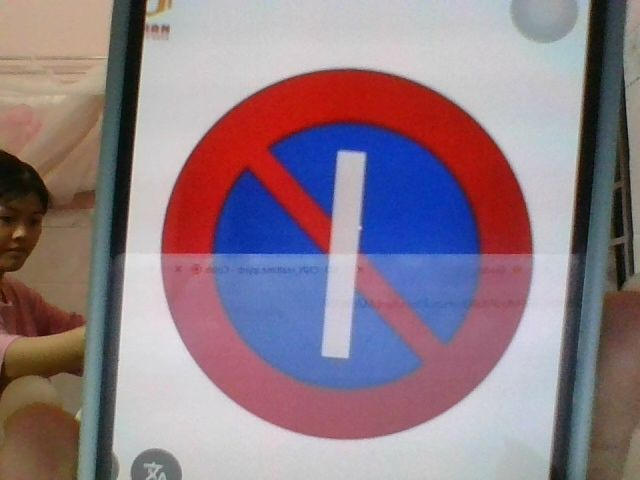

Kết quả dự đoán:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Duong Danh Cho Nguoi Di Bo


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

img = load_img('photo.jpg',target_size=(64,64))
#plt.imshow(img)
img = img_to_array(img)
img=img.reshape(1,64,64,3)
img=img.astype('float32')
img = img/255
print("Kết quả dự đoán:")
print(classes[np.argmax(model.predict(img))])